# REINFORCE Agent

## Setup step

In [26]:
%sudo apt-get update
%pip install scipy
%pip install tensorflow
%pip install tf-agents
%pip install dm-reverb[tensorflow]

UsageError: Line magic function `%sudo` not found.


In [27]:
import tensorflow as tf
import numpy as np
import tf_agents

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
import matplotlib.animation as animation


from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import py_tf_eager_policy
from tf_agents.drivers import py_driver
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver

import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

from tf_env.UR_ENV import UR_env

## Giperparameters

In [28]:
number_iterations = 100 # @param {type:"integer"}
discount = 0.99 # @param {type:"number"}
fc_layer_params=(256,256)
learning_rate = 1e-3 # @param {type:"number"}
number_eval_episodes = 10 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
# collect_max_steps = 20 # @param {type:"integer"}
replay_buffer_capacity = 10000 # @param {type:"integer"}
log_interval = 15 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}


## Environment
Usually we create two environments: one for training and one for evaluation. Most environments are written in pure python, but they can be easily converted to TensorFlow using the TFPyEnvironment wrapper. The original environment's API uses numpy arrays, the TFPyEnvironment converts these to/from Tensors for you to more easily interact with TensorFlow policies and agents.

In [29]:
train_env_py= UR_env()
eval_env_py=UR_env()

train_env_tf=tf_py_environment.TFPyEnvironment(train_env_py)
eval_env_tf=tf_py_environment.TFPyEnvironment(eval_env_py)

In [30]:
train_env_tf.observation_spec()

BoundedTensorSpec(shape=(2, 3), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32))

In [31]:
train_env_tf.action_spec()

BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='action', minimum=array(-1., dtype=float32), maximum=array(1., dtype=float32))

In [32]:
train_env_tf.discount_spec()

BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0)

In [33]:
train_env_tf.reward_spec()

TensorSpec(shape=(), dtype=tf.float32, name='reward')

In [34]:
train_env_tf.time_step_spec()

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(2, 3), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [35]:
train_env_tf.current_time_step()

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 2, 3), dtype=float32, numpy=
array([[[  85.35, -194.25,  608.8 ],
        [   0.  ,   90.  ,  -90.  ]]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})

## Agent
### Actor Network Policies
The algorithm that we use to solve an RL problem is represented as an Agent. In addition to the REINFORCE agent, TF-Agents provides standard implementations of a variety of Agents such as DQN, DDPG, TD3, PPO and SAC.

To create a REINFORCE Agent, we first need an Actor Network that can learn to predict the action given an observation from the environment.

We can easily create an Actor Network using the specs of the observations and actions. We can specify the layers in the network which, in this example, is the fc_layer_params argument set to a tuple of ints representing the sizes of each hidden layer (see the Hyperparameters section above).

In [36]:
from tf_agents.networks import actor_distribution_network

actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env_tf.observation_spec(),
    train_env_tf.action_spec(),
    fc_layer_params=fc_layer_params)

We also need an optimizer to train the network we just created, and a train_step_counter variable to keep track of how many times the network was updated.

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [38]:
train_step_counter = tf.Variable(0)

In [39]:
tf_agent = reinforce_agent.ReinforceAgent(
    train_env_tf.time_step_spec(),
    train_env_tf.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [40]:
tf_agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(6,), dtype=tf.float32, name='action', minimum=array(-1., dtype=float32), maximum=array(1., dtype=float32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(2, 3), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

## Policies
In TF-Agents, policies represent the standard notion of policies in RL: given a time_step produce an action or a distribution over actions. The main method is policy_step = policy.action(time_step) where policy_step is a named tuple PolicyStep(action, state, info). The policy_step.action is the action to be applied to the environment, state represents the state for stateful (RNN) policies and info may contain auxiliary information such as log probabilities of the actions.

Agents contain two policies: the main policy that is used for evaluation/deployment (agent.policy) and another policy that is used for data collection (agent.collect_policy).

In [41]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

## Metrics and Evaluation
The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes. We can compute the average return metric as follows.

In [42]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]



## Replay Buffer
Reinforcement learning algorithms use replay buffers to store trajectories of experience when executing a policy in an environment. During training, replay buffers are queried for a subset of the trajectories (either a sequential subset or a sample) to "replay" the agent's experience.

In TF-Agents we use a Driver (see the Driver tutorial for more details) to collect experience in an environment. To use a Driver, we specify an Observer that is a function for the Driver to execute when it receives a trajectory.

TFUniformReplayBuffer is the most commonly used replay buffer in TF-Agents, thus we will use here. In TFUniformReplayBuffer the backing buffer storage is done by tensorflow variables and thus is part of the compute graph.

The buffer stores batches of elements and has a maximum capacity max_length elements per batch segment. Thus, the total buffer capacity is batch_size x max_length elements. The elements stored in the buffer must all have a matching data spec. When the replay buffer is used for data collection, the spec is the agent's collect data spec.

In [43]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      tf_agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
      replay_buffer_signature)
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    table_name=table_name,
    sequence_length=None,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp04mnmg_a.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmp04mnmg_a
[reverb/cc/platform/default/server.cc:71] Started replay server on port 36073
[reverb/cc/platform/default/server.cc:84] Shutting down replay server


As REINFORCE learns from whole episodes, we define a function to collect an episode using the given data collection policy and save the data (observations, actions, rewards etc.) as trajectories in the replay buffer. Here we are using 'PyDriver' to run the experience collecting loop. 

In [44]:
def collect_episode(environment, policy, max_episodes):
  driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(
      policy, use_tf_function=True),
    [rb_observer],
    max_episodes=max_episodes)
  initial_time_step = environment.reset()
  driver.run(initial_time_step)

## Training the agent
The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

In [45]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env_tf, tf_agent.policy, number_eval_episodes)
returns = [avg_return]

# print(returns)

In [46]:
for _ in range(number_iterations):
  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_env_py, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  data_set = replay_buffer.as_dataset(sample_batch_size=2)
  iterator = iter(data_set)
  trajectories, _ = next(iterator)
  train_loss = tf_agent.train(experience=trajectories)

  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env_tf, tf_agent.policy, number_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)



step = 15: loss = 0.9237375259399414


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (17801) so Table uniform_table is accessed directly without gRPC.


step = 30: loss = 0.9221475124359131
step = 45: loss = -6.543303489685059
step = 50: Average Return = -23.720029830932617
step = 60: loss = -5.998488426208496
step = 75: loss = -5.903724670410156
step = 90: loss = -8.18832778930664
step = 100: Average Return = -23.720029830932617


KeyboardInterrupt: 

## Visualization

(28.35, 100.0)

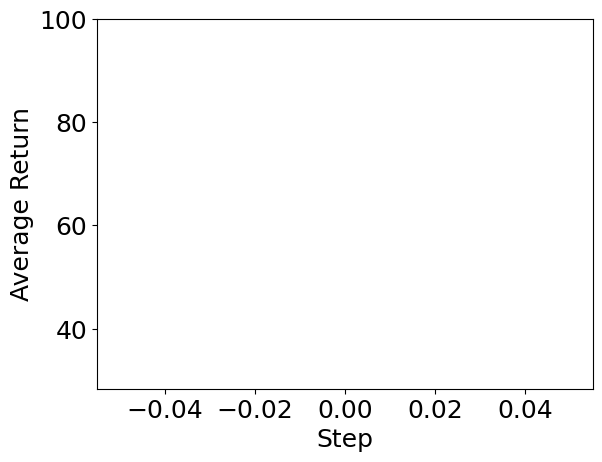

In [ ]:
steps = range(0, number_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=100)

## Animation

In [ ]:
from matplotlib import animation
def compute_animation_frames(environment, policy, size_episodes=1):
    frame = []
    for _ in range(size_episodes):
        time_step = environment.reset()
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            img = environment.render()
            frame.append(img)
    return frame

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=80):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
frames = compute_animation_frames(eval_env_py,tf_agent.policy)


TypeError: Image data of dtype object cannot be converted to float

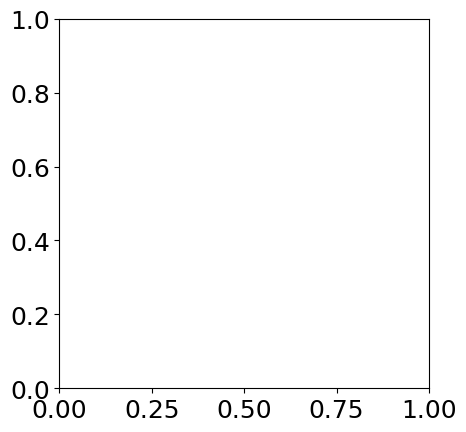

In [ ]:
plot_animation(frames)